<a href="https://colab.research.google.com/github/dudaholandah/NLP/blob/main/Trabalhos/T7/Atividade_07_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Inferência de Linguagem Natural

```
Alunas:
Maria Eduarda Holanda 190043725
Tong Zhou 190038764
```

In [ ]:
!pip install -U keras
!pip install tensorflow

In [ ]:
!pip install tensorflow-datasets

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import csv
import os
from keras.models import Sequential, Model
from keras.layers import Dense,Activation, Input,SimpleRNN,Embedding,Dropout,GlobalMaxPooling1D,MaxPooling1D,Flatten,LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets.public_api as tfds
from keras.utils.np_utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

##Corpus SNLI

Obs: Otimização de hiperparametros

In [ ]:
ds_train = tfds.load('snli', split='train[:50%]', shuffle_files=True)
ds_valid = tfds.load('snli', split='validation', shuffle_files=False)
ds_test = tfds.load('snli', split='test', shuffle_files=False)
ds_train

<PrefetchDataset element_spec={'hypothesis': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'premise': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [ ]:
df_train = tfds.as_dataframe(ds_train)
df_valid = tfds.as_dataframe(ds_valid)
df_test = tfds.as_dataframe(ds_test)

In [ ]:
df_test.head()

,hypothesis,label,premise
0,b'A girl is entertaining on stage',0,b'A girl in a blue leotard hula hoops on a sta...
1,b'A group of people posing in front of a body ...,0,b'A group of people taking pictures on a walkw...
2,"b""The group of people aren't inide of the buil...",0,b'Many people standing outside of a place talk...
3,b'The people are taking a carriage ride.',0,b'Three people are riding a carriage pulled by...
4,b'Two girls are getting ready to ride horses.',1,b'Two girls feeding a horse an apple.'


In [ ]:
df_train['hypothesis'] = [x.decode('utf-8') for x in df_train['hypothesis']] 
df_train['premise'] = [x.decode('utf-8') for x in df_train['premise']] 

df_valid['hypothesis'] = [x.decode('utf-8') for x in df_valid['hypothesis']] 
df_valid['premise'] = [x.decode('utf-8') for x in df_valid['premise']] 

df_test['hypothesis'] = [x.decode('utf-8') for x in df_test['hypothesis']] 
df_test['premise'] = [x.decode('utf-8') for x in df_test['premise']] 

In [ ]:
df_test.head()

,hypothesis,label,premise
0,A girl is entertaining on stage,0,A girl in a blue leotard hula hoops on a stage...
1,A group of people posing in front of a body of...,0,A group of people taking pictures on a walkway...
2,The group of people aren't inide of the building.,0,Many people standing outside of a place talkin...
3,The people are taking a carriage ride.,0,Three people are riding a carriage pulled by f...
4,Two girls are getting ready to ride horses.,1,Two girls feeding a horse an apple.


In [ ]:
df_train['label'] = pd.Categorical(df_train['label'])
y_train_int = df_train['label'].cat.codes

df_valid['label'] = pd.Categorical(df_valid['label'])
y_valid_int = df_valid['label'].cat.codes

df_test['label'] = pd.Categorical(df_test['label'])
y_test_int = df_test['label'].cat.codes

In [ ]:
y_train = to_categorical(y_train_int)
y_valid = to_categorical(y_valid_int)
y_test = to_categorical(y_test_int)

In [ ]:
train_tweets = df_train['premise'].to_list() + df_train['hypothesis'].to_list()

vocabulary = {}

for i in range(0,len(train_tweets)):
    train_tweets[i] = train_tweets[i].lower()
    for word in train_tweets[i].split():
        if word not in vocabulary:
            vocabulary[word] = 1
        else:
            vocabulary[word]+=1

In [ ]:
vocab_size = len(vocabulary)

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(df_train['hypothesis'] + df_train['premise'])

In [ ]:
train_sequences = tokenizer.texts_to_sequences(df_train['hypothesis'] + df_train['premise'])

##Pós-processamento da numericalização

In [ ]:
max_words = 105

hist = {}

hist['qtde'] = [x for x in range(0,max_words)]

lista = [0]*(max_words)
for x in train_sequences:
    lista[len(x)]+=1

hist['num tweets'] = lista

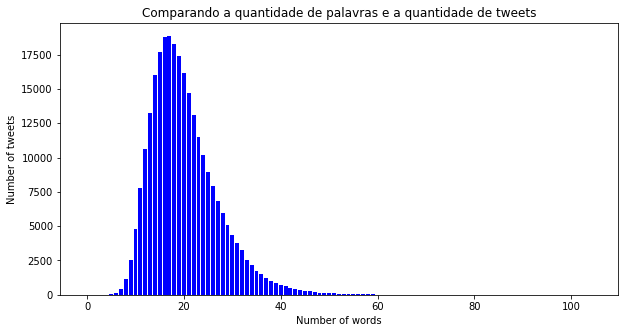

In [ ]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(hist['qtde'],hist['num tweets'],
        color ='blue')
 
plt.xlabel("Number of words")
plt.ylabel("Number of tweets")
plt.title("Comparando a quantidade de palavras e a quantidade de tweets")
plt.show()

##RNN 

In [ ]:
max_length = 60

In [ ]:
trunc_type = 'post'
padding_type = 'post'
train_padded = pad_sequences(train_sequences,max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
valid_sequences = tokenizer.texts_to_sequences(df_valid['hypothesis'] + df_valid['premise'])
test_sequences = tokenizer.texts_to_sequences(df_test['hypothesis'] + df_test['premise'])

valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim = 64))
model.add(SimpleRNN(128,return_sequences=True,activation='relu'))
model.add(Dropout(0.5))
model.add(SimpleRNN(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation="softmax"))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 64)          2904128   
                                                                 
 simple_rnn_22 (SimpleRNN)   (None, None, 128)         24704     
                                                                 
 dropout_18 (Dropout)        (None, None, 128)         0         
                                                                 
 simple_rnn_23 (SimpleRNN)   (None, 64)                12352     
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 4)                 260       
                                                                 
Total params: 2,941,444
Trainable params: 2,941,444
No

In [ ]:
#input1 = Input(shape=(3,1))
#rnn_output = SimpleRNN(1,return_sequences= True, activation='relu')(input1)
#model = Model(inputs=input1, outputs=rnn_output)

#t = [0.4,0.6,0.3]
#p = model.predict(array(t).reshape(1,3,1))
#print(p)
#model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 simple_rnn_17 (SimpleRNN)   (None, 3, 1)              3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [ ]:
sgd = SGD(learning_rate=0.01)
model.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])
history_fine = model.fit(train_padded,y_train,validation_data=(valid_padded,y_valid),epochs=10)

Epoch 1/10
8597/8597 [==============================] - 407s 47ms/step - loss: 1.1205 - accuracy: 0.3328 - val_loss: 1.1901 - val_accuracy: 0.3278
Epoch 2/10
8597/8597 [==============================] - 402s 47ms/step - loss: 1.1112 - accuracy: 0.3336 - val_loss: 1.1849 - val_accuracy: 0.3330
Epoch 3/10
8597/8597 [==============================] - 430s 50ms/step - loss: 1.1104 - accuracy: 0.3325 - val_loss: 1.1847 - val_accuracy: 0.3278
Epoch 4/10
8597/8597 [==============================] - 402s 47ms/step - loss: 1.1100 - accuracy: 0.3338 - val_loss: 1.1842 - val_accuracy: 0.3329
Epoch 5/10
8597/8597 [==============================] - 408s 47ms/step - loss: 1.1098 - accuracy: 0.3316 - val_loss: 1.1897 - val_accuracy: 0.3329
Epoch 6/10
8597/8597 [==============================] - 399s 46ms/step - loss: 1.1096 - accuracy: 0.3341 - val_loss: 1.1823 - val_accuracy: 0.3278
Epoch 7/10
8597/8597 [==============================] - 409s 48ms/step - loss: 1.1095 - accuracy: 0.3325 - val_loss: 1

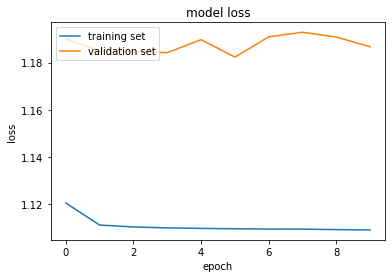

In [ ]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

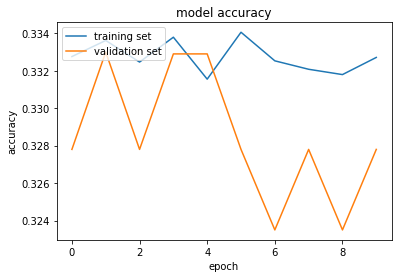

In [ ]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [ ]:
y_prob = model.predict(test_padded)
y_pred = np.argmax(y_prob,axis=1)

In [ ]:
print(classification_report(y_test_int,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       176
           1       0.00      0.00      0.00      3368
           2       0.00      0.00      0.00      3219
           3       0.32      1.00      0.49      3237

    accuracy                           0.32     10000
   macro avg       0.08      0.25      0.12     10000
weighted avg       0.10      0.32      0.16     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##LSTM

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=max_length, input_length=max_length))
model.add(LSTM(32))
model.add(Activation('relu'))
model.add(Dense(4))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 60, 60)            2722620   
                                                                 
 lstm_2 (LSTM)               (None, 32)                11904     
                                                                 
 activation_1 (Activation)   (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 4)                 132       
                                                                 
 activation_2 (Activation)   (None, 4)                 0         
                                                                 
Total params: 2,734,656
Trainable params: 2,734,656
Non-trainable params: 0
_________________________________________________________________


In [ ]:
max_length = 40

In [ ]:
sgd = SGD(learning_rate=0.01)
model.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])
history_fine = model.fit(train_padded,y_train,validation_data=(valid_padded,y_valid),epochs=10)

In [ ]:
#Keras Tuner
#!pip install keras-tuner --upgrade